## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 

### Load the dataset

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression

In [86]:
data = pd.read_csv("data/bank-full.csv", sep=";")

### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`

In [87]:
data = data.drop(columns=["loan", "default"], axis=1)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [88]:
X = data.drop("y", axis=1)
y = (data.y == "yes").astype(int)

In [89]:
X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.25, random_state=1)

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`

In [90]:
numerical_col = data.select_dtypes(include=["int64"])

numerical_vars = numerical_col.columns

In [91]:
numerical_vars

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

In [92]:
for var in numerical_vars:
    auc = roc_auc_score(y_full, X_full[var])
     # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(y_full, -X_full[var])
    print(f'AUC for {var}: {auc:.3f}')

AUC for age: 0.509
AUC for balance: 0.592
AUC for day: 0.528
AUC for duration: 0.810
AUC for campaign: 0.573
AUC for pdays: 0.592
AUC for previous: 0.601


_Duration has the highest AUC(0.810)_

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99

In [93]:
dv = DictVectorizer(sparse=False)

X_transform = X_train.to_dict(orient='records')
X_val_transform = X_val.to_dict(orient='records')

X_train_f = dv.fit_transform(X_transform)
X_val_f = dv.transform(X_val_transform)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_f, y_train)

#y_pred = model.predict(X_val_f)
y_pred = model.predict_proba(X_val_f)[:, 1]


auc = roc_auc_score(y_val, y_pred)

In [94]:
round(auc, 3)

0.9

_0.89 is closet to the solution_

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865

In [109]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    y_pred = model.predict_proba(X_val_f)[:, 1]
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    #precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    #recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    scores.append((t, tp, tn, fp, fn))
    
    
columns = ["thresholds", "tp", "tn", "fp", "fn"]
    
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [110]:
df_scores[::10]

,thresholds,tp,tn,fp,fn,precision,recall
0,0.0,1098,0,7944,0,0.121433,1.000000
10,0.1,926,6451,1493,172,0.382803,0.843352
20,0.2,712,7252,692,386,0.507123,0.648452
30,0.3,565,7537,407,533,0.581276,0.514572
40,0.4,463,7672,272,635,0.629932,0.421676
50,0.5,373,7753,191,725,0.661348,0.339709
60,0.6,291,7807,137,807,0.679907,0.265027
70,0.7,225,7843,101,873,0.690184,0.204918
80,0.8,148,7876,68,950,0.685185,0.134791
90,0.9,76,7916,28,1022,0.730769,0.069217


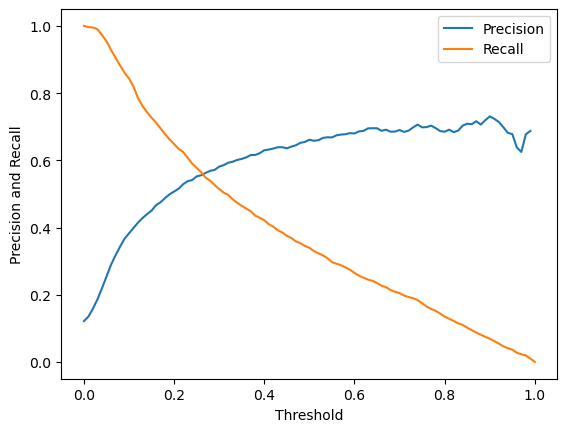

In [111]:
plt.plot(df_scores.thresholds, df_scores['precision'], label='Precision')
plt.plot(df_scores.thresholds, df_scores['recall'], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Precision and Recall")
plt.legend();

_Answer is 0.265_

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [122]:
df_scores["f1"] = 2 * ((df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))

best_threshold_idx = df_scores['f1'].idxmax()
best_threshold = df_scores.loc[best_threshold_idx, 'thresholds']
best_f1 = df_scores.loc[best_threshold_idx, 'f1']

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.2f}")

Best Threshold: 0.22
Best F1 Score: 0.57


_Answer is 0.22_

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [133]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

dv = DictVectorizer(sparse=False)
scores = []

for train_idx , val_idx in kfold.split(X_full):
    df_train = X_full.iloc[train_idx]
    df_val = X_full.iloc[val_idx]
    
    df_train = df_train.to_dict(orient='records')
    df_val = df_val.to_dict(orient='records')
    
    y_train = y_full.iloc[train_idx]
    y_val = y_full.iloc[val_idx]
    
    X_train_trans = dv.fit_transform(df_train)
    X_val_trans = dv.transform(df_val)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_trans, y_train)
    
    y_pred = model.predict_proba(X_val_trans)[:, 1]
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    
print(f"STD: {np.std(scores)}")

STD: 0.005322127966605898


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [135]:
for C in tqdm([0.000001, 0.001, 1]):

    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    dv = DictVectorizer(sparse=False)
    scores = []

    for train_idx , val_idx in kfold.split(X_full):
        df_train = X_full.iloc[train_idx]
        df_val = X_full.iloc[val_idx]
        
        df_train = df_train.to_dict(orient='records')
        df_val = df_val.to_dict(orient='records')
        
        y_train = y_full.iloc[train_idx]
        y_val = y_full.iloc[val_idx]
        
        X_train_trans = dv.fit_transform(df_train)
        X_val_trans = dv.transform(df_val)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_trans, y_train)
        
        y_pred = model.predict_proba(X_val_trans)[:, 1]
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print(f"C:{C}, Mean:{np.mean(scores):.3f}, STD:{np.std(scores):.3f}")
    

  0%|          | 0/3 [00:00<?, ?it/s]

C:1e-06, Mean:0.701, STD:0.009
C:0.001, Mean:0.861, STD:0.007
C:1, Mean:0.906, STD:0.005


_The C with the best mean score is C=1_